
# Notes


## Overview

- Two stage Sampling Used for CondiSeg but not (Seg Both Mode). I would like to do another experiment with two stage sampling turned on for SegBoth.
- Reversed CondiSeg Results should be finished this morning. Will need to incorporate.
- Concern about the poor segmentation on the CT Image. Why is this? Empirical knowledge shows DICE should be above 90% for other anatomical segmentation. Would expect 70 - 80 DICE for bladder. 

## Todo:


- Run each model at their best epoch under 20K on the Test set.
- Confidence Intervals on the Test Metric (aggregating over folds).
- Confidence Intervals for Validation Metric (aggregating over folds).
- Rerun Segmentation of CBCT and CT (Seg Both Mode) with two-stage sampling.
- Plot Standard Deviation with the Mean DICE for validation and test on same plot.
- Look at predictions see if there are any obvious problems with all images.
    -- Is the wrong anatomical structure being segmented? 






# Preprocessing

## Installs

In [1]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn

## Imports

In [2]:
import os
import sys
import pathlib
print(pathlib.Path().resolve())
from glob import glob

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



/home/bot/thesis/conditional_segmentation_thesis


## Create DataFrame

In [3]:
#Get files containing logs
pattern = './Experiments/**/running_logs/*' #Gets all the log files
files = glob(pattern, recursive=True)
[print(i) for i in files if not None]


./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv4_nc16_train_log_4.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv2_nc16_train_log_2.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv0_nc16_train_log_0.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv7_nc16_train_log_7.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv1_nc16_train_log_1.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv6_nc16_train_log_6.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSeg/running_logs/CondisegCBCT_cv3_nc16_train_log_3.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSegReversed/running_logs/CondisegReversed_cv0_nc16_train_log_0.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSegReversed/running_logs/CondisegReversed_cv2_nc16_train_log_2.txt
./Experiments/exp_2_CS_and_CSRev/ConditionalSegReversed/running_logs/CondisegReversed

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
#Get First File
df = pd.read_csv(files[0])

#Join rest of files without header.
df = pd.concat([df] + [pd.read_csv(i) for i in files[1:]], ignore_index = True, axis = 0)
df.head(500) #Quick check

,project,exp_name,fold,train_val_test,epoch,value,value_type
0,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',1.0,0.886185,'loss'
1,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1.0,0.080423,'dice_mean'
2,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1.0,0.07059,'dice_std'
3,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',2.0,0.89479,'loss'
4,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',2.0,0.014435,'dice_mean'
...,...,...,...,...,...,...,...
495,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',166.0,0.22984,'loss'
496,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',166.0,0.49074,'dice_mean'
497,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',166.0,0.214648,'dice_std'
498,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',167.0,0.246141,'loss'


In [5]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945418 entries, 0 to 2945417
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   project         object 
 1   exp_name        object 
 2   fold            object 
 3   train_val_test  object 
 4   epoch           float64
 5   value           object 
 6   value_type      object 
dtypes: float64(1), object(6)
memory usage: 157.3+ MB
None
              epoch
count  2.945418e+06
mean   1.104155e+04
std    6.722246e+03
min    6.131642e-01
25%    5.436000e+03
50%    1.077200e+04
75%    1.610800e+04
max    3.219800e+04
          project               exp_name fold train_val_test  epoch     value  \
0  ConditionalSeg  CondisegCBCT_cv4_nc16    4        'train'    1.0  0.886185   
1  ConditionalSeg  CondisegCBCT_cv4_nc16    4          'val'    1.0  0.080423   
2  ConditionalSeg  CondisegCBCT_cv4_nc16    4          'val'    1.0   0.07059   
3  ConditionalSeg  CondisegCBCT_cv4_nc16    4        'train'    

In [6]:
list(df.exp_name.unique())

['CondisegCBCT_cv4_nc16',
 'CondisegCBCT_cv2_nc16',
 '0',
 'CondisegCBCT_cv0_nc16',
 'CondisegCBCT_cv7_nc16',
 'CondisegCBCT_cv1_nc16',
 'CondisegCBCT_cv6_nc16',
 'CondisegCBCT_cv3_nc16',
 'CondisegReversed_cv0_nc16',
 'CondisegReversed_cv2_nc16',
 'CondisegReversed_cv6_nc16',
 'CondisegReversed_cv7_nc16',
 'CondisegReversed_cv3_nc16',
 'CondisegReversed_cv5_nc16',
 'CondisegReversed_cv1_nc16',
 'CondisegCBCT_cv5_nc16',
 'segModeCBCTCV4',
 'segModeBothCV5',
 'segModeBothCV1',
 'segModeCBCTCV1',
 'segModeCTCV4',
 'segModeBothCV3',
 'segModeBothCV2',
 'segModeCTCV3',
 'segModeCTCV5',
 'segModeCBCTCV6',
 'segModeBothCV6',
 'segModeCTCV1',
 'segModeCBCTCV5',
 'segModeCBCTCV0',
 'segModeCBCTCV2',
 'segModeBothCV7',
 'segModeBothCV4',
 'segModeCTCV7',
 'segModeCTCV2',
 'segModeCTCV6',
 'segModeCBCTCV7',
 'segModeCBCTCV3',
 'segModeBothCV0',
 'segModeCTCV0']

In [7]:
df.drop(df[df['exp_name'] =='0'].index, inplace=True)

In [8]:
#One was a NaN which was obviously a condisegreversed by exp_name. Update to the correct project
df[df['project'].isna()] = 'ConditionalSegReversed'

In [9]:
df.drop(df[df['exp_name'] == 'ConditionalSegReversed'].index, inplace=True)

In [15]:
#Convert Fields to correct type
df['value'] = df['value'].astype(float)
df['fold'] = df['fold'].astype(int)
df['project'] = df['project'].astype(str)
df['exp_name'] = df['exp_name'].astype(str)
df['epoch'] = df['epoch'].astype(int)
df['train_val_test'].str.replace("'", "")
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2945416 entries, 0 to 2945417
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   project         object 
 1   exp_name        object 
 2   fold            int64  
 3   train_val_test  object 
 4   epoch           int64  
 5   value           float64
 6   value_type      object 
dtypes: float64(1), int64(2), object(4)
memory usage: 179.8+ MB


## Experiment Setup
I need to present analysis on the results. 

In [16]:
projects = df.project.unique().tolist() #Get unique projects
projects

['ConditionalSeg', 'ConditionalSegReversed', 'CBCTUnetSeg']

In [17]:
experiments = list(df.exp_name.unique()) #get unique experiments
print(experiments.sort())
experiments
exp_types = ['CondisegCBCT', 'condisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT']

None


In [18]:
exp_type = exp_types[0]
df[df['exp_name'].str.startswith(exp_type)] 

,project,exp_name,fold,train_val_test,epoch,value,value_type
0,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',1,0.886185,'loss'
1,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.080423,'dice_mean'
2,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.070590,'dice_std'
3,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',2,0.894790,'loss'
4,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',2,0.014435,'dice_mean'
...,...,...,...,...,...,...,...
1505413,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28205,0.805212,'dice_mean'
1505414,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28205,0.171456,'dice_std'
1505415,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'train',28206,0.054929,'loss'
1505416,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28206,0.811183,'dice_mean'


In [19]:
df.head()

,project,exp_name,fold,train_val_test,epoch,value,value_type
0,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',1,0.886185,'loss'
1,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.080423,'dice_mean'
2,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.070590,'dice_std'
3,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',2,0.894790,'loss'
4,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',2,0.014435,'dice_mean'


In [20]:
projects = df.project.unique().tolist() #Get unique projects
projects

['ConditionalSeg', 'ConditionalSegReversed', 'CBCTUnetSeg']

In [21]:
experiments = list(df.exp_name.unique()) #get unique experiments
print(experiments.sort())
experiments
exp_types = ['CondisegCBCT', 'condisegReversed', 'segModeBoth', 'segModeCBCT', 'segModeCT']

None


In [22]:
exp_type = exp_types[0]
df[df['exp_name'].str.startswith(exp_type)] 

,project,exp_name,fold,train_val_test,epoch,value,value_type
0,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',1,0.886185,'loss'
1,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.080423,'dice_mean'
2,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',1,0.070590,'dice_std'
3,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'train',2,0.894790,'loss'
4,ConditionalSeg,CondisegCBCT_cv4_nc16,4,'val',2,0.014435,'dice_mean'
...,...,...,...,...,...,...,...
1505413,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28205,0.805212,'dice_mean'
1505414,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28205,0.171456,'dice_std'
1505415,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'train',28206,0.054929,'loss'
1505416,ConditionalSeg,CondisegCBCT_cv3_nc16,3,'val',28206,0.811183,'dice_mean'


In [23]:
#Creata a dictionary to map experiment name to a friendly name to be displayed on the chart for the corresponding experiment.
exp_name_title_mapping = {'CondisegCBCT': "Conditional Segmentation Algorithm",
                          'condisegReversed': "Conditional Segmentation Algorithm (Reversed)",
                          'segModeBoth': "CBCT & CT Segmentation",
                          'segModeCBCT': "CBCT Segmentation",
                          'segModeCT': "CT Segmentation"}


## Plot Helpers

In [39]:
#Creata a dictionary to map experiment name to a friendly name to be displayed on the chart for the corresponding experiment.
exp_name_title_mapping = {'CondisegCBCT': "Conditional Segmentation Algorithm",
                          'condisegReversed': "Conditional Segmentation Algorithm (Reversed)",
                          'segModeBoth': "CBCT & CT Segmentation",
                          'segModeCBCT': "CBCT Segmentation",
                          'segModeCT': "CT Segmentation"}

exp_grouping = {}
#Create a dictionary to map experiment name to a list of experiments that are part of the same group.
#Loop through all unique experiment names (one for each fold per experiment)
for exp_name in df.exp_name.unique().tolist():
    #Then loop through the exp_types which are unique exp_name prefixes. Map to the Grouping

    #print(f"exp_name: {exp_name}")
    for exp_type in exp_name_title_mapping.keys():
        #print(f'exp_type: {exp_type}')
        if exp_name.startswith(exp_type):
            exp_grouping[exp_name] = exp_name_title_mapping[exp_type]
            break #break out of the loop since we found the exp_type
#print(exp_grouping)

df['experiment_group'] = df['exp_name'].map(exp_grouping)

def plot_data_aggregate(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch, title = None, y_label = 'Value'):
    

    # 
    df_local = df[df['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
    df_local = df_local[df_local['train_val_test'] == train_val_test] #only get training, validation, or test data
    df_local = df_local[df_local['value_type'] == value_type] #only get loss, dice_mean, or dice_std data
    df_local = df_local[df_local['epoch'] <= max_epochs] #Only get data for first 20k epochs
    df_local = df_local.groupby(['experiment_group', 'epoch'], as_index=False).agg({"value": np.mean})
    
    plot = sns.lineplot(x='epoch', y='value', hue='experiment_group', data=df_local, markers=True)

    plot.set(title=title, xlabel='Epoch', ylabel=y_label) #Set title and labels
    plt.show()


#TEST
#plot_data_aggregate(exp_types,

In [43]:
def plot_data_by_folds(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch, y_label):
    for exp_type in exp_types:
        df_experiment = df[df['exp_name'].str.startswith(exp_type)] #Only get data for this experiment
        df_experiment = df_experiment[df_experiment['epoch'] <= max_epochs] #Only get data for first 20k epochs
        df_experiment = df_experiment[df_experiment['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
        df_experiment = df_experiment[df_experiment['train_val_test'] == train_val_test] #only get training, validation, or test data
        df_experiment = df_experiment[df_experiment['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data
        plot = sns.lineplot(x='epoch', y='value', hue='fold', data=df_experiment, ci = None)
        #plot.set_ylim([0, 0.4])
        plot.set(title=f"{exp_name_title_mapping[exp_type]}", xlabel='Epoch', ylabel=y_label) #Set title and labels
        plot.legend(title='Fold')
        plt.show()
        plt.clf()

In [25]:
def plot_data_aggregate_by_fold(exp_types, train_val_test, value_type, max_epochs, every_nth_epoch):
    for exp_type in exp_types:
        df_experiment = df[df['exp_name'].str.startswith(exp_type)] #Only get data for this experiment
        df_experiment = df_experiment[df_experiment['epoch'] <= max_epochs] #Only get data for first 20k epochs
        df_experiment = df_experiment[df_experiment['epoch'] % every_nth_epoch == 0] #Only get data for every 1000 epochs
        df_experiment = df_experiment[df_experiment['train_val_test'] == train_val_test] #only get training, validation, or test data
        df_experiment = df_experiment[df_experiment['value_type'] == value_type][['epoch', 'value', 'fold']] #only get loss data
        x = df_experiment.groupby(['epoch'], as_index=False).agg({"value": np.mean})
        plot = sns.lineplot(x='epoch', y='value', data=x)
        plot.set(title=f"{exp_name_title_mapping[exp_type]} by Epoch", xlabel='Epoch', ylabel='Loss') #Set title and labels
        plt.show()
        plt.clf()

#TEST
#plot_data_aggregate_by_fold(exp_types, "'val'", "'dice_mean'", 20000, 1000)

# Ploting

## Training Loss Convergence Analysis By Fold

### By Fold

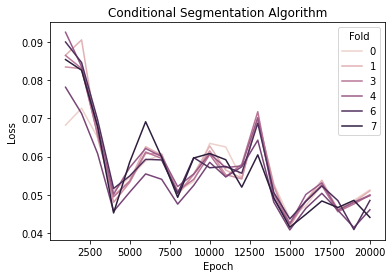

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


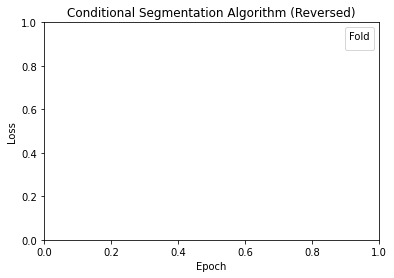

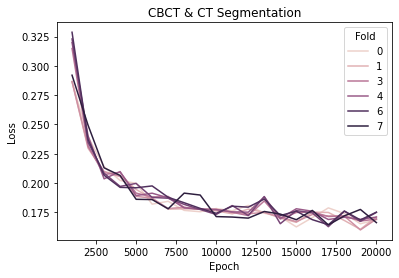

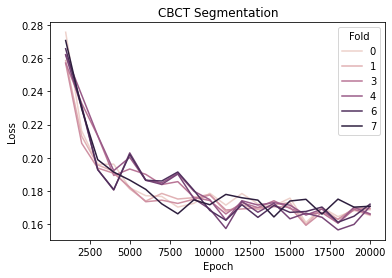

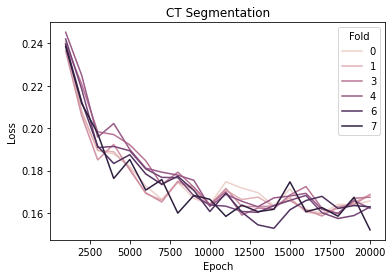

<Figure size 432x288 with 0 Axes>

In [45]:
#Plot an epoch vs Loss graph for the Conditional Segmentation Algorithm 
#Shaded areas are 95% Confidence Intervals of the Mean with 1000 bootstrap samples.
train_val_test = "'train'"
value_type = "'loss'"

plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 1000, 'Loss')


### By Experiment

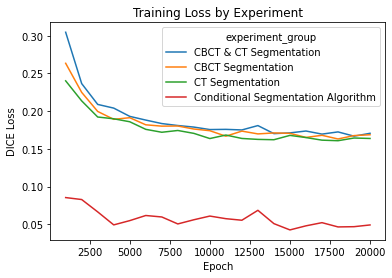

In [41]:
plot_data_aggregate(exp_types, "'train'", "'loss'", 20000, 1000, title='Training Loss by Experiment', y_label = 'DICE Loss')

## Validation Data Mean DICE Score

### By Fold

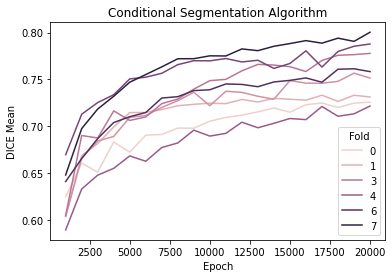

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


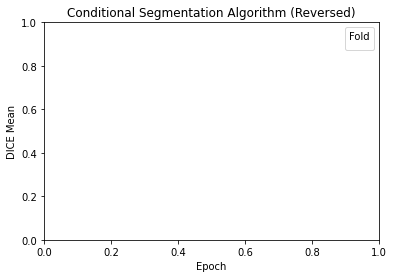

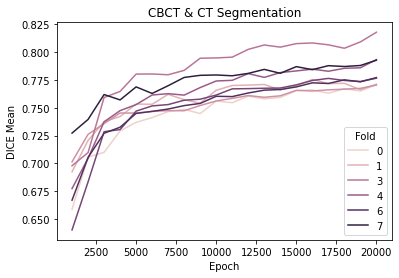

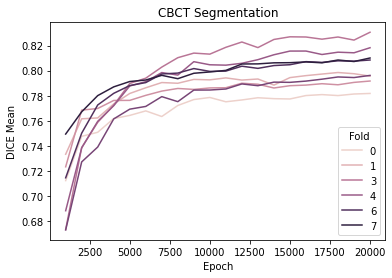

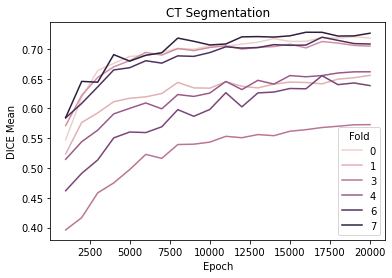

<Figure size 432x288 with 0 Axes>

In [44]:
train_val_test = "'val'"
value_type = "'dice_mean'"
plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 1000, y_label = 'Mean DICE')
#todo fix ylabel

### By Experiment

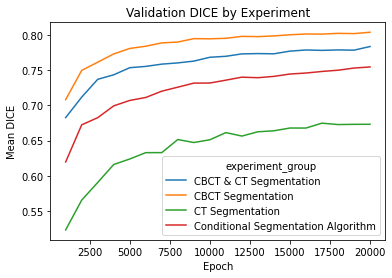

In [46]:
plot_data_aggregate(exp_types, "'val'", "'dice_mean'", 20000, 1000, title='Validation DICE by Experiment', y_label = 'Mean DICE')

#Notes from Yipeng
Would expect CT to be performing better as there is more information in CT images. Why is CT Lower?

## Validation DICE Standard Deviation

### By Fold

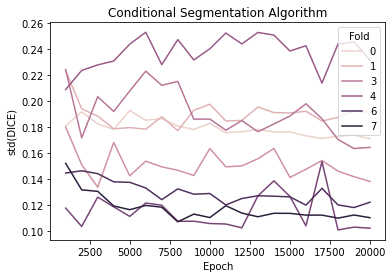

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


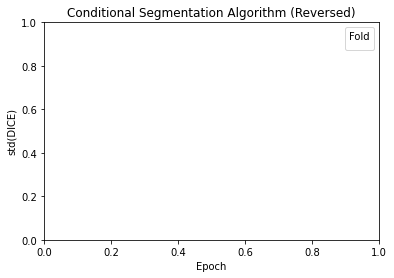

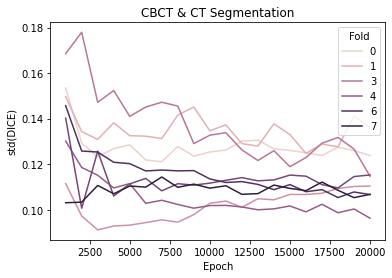

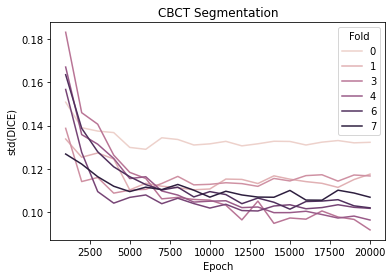

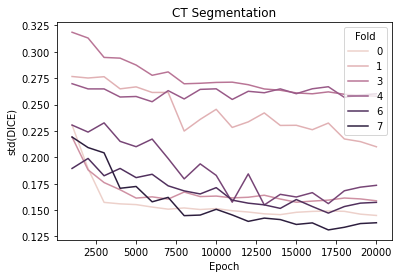

<Figure size 432x288 with 0 Axes>

In [48]:
train_val_test = "'val'"
value_type = "'dice_std'"
plot_data_by_folds(exp_types, train_val_test, value_type, 20000, 1000, y_label='std(DICE)')
#todo fix ylabel

### By Experiment

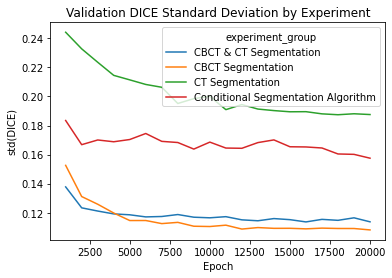

In [47]:
plot_data_aggregate(exp_types, "'val'", "'dice_std'", 20000, 1000, title='Validation DICE Standard Deviation by Experiment', y_label = 'std(DICE)')

## Test Mean Dice


### By Fold

In [52]:
import pickle as pkl

In [53]:
test_path = 'Experiments/exp_2_CS_and_CSRev/ConditionalSegReversed/CondisegReversed_cv0_nc16/results.pkl'

with open (test_path, 'rb') as f:
    results = pkl.load(f)

results


{'dice': [array(0.8794943, dtype=float32),
  array(0.6041194, dtype=float32),
  array(0.9488654, dtype=float32),
  array(0.86145145, dtype=float32),
  array(0.9355941, dtype=float32),
  array(0.44710892, dtype=float32),
  array(0.90577024, dtype=float32),
  array(0.78423125, dtype=float32),
  array(0.9367728, dtype=float32),
  array(0.7999395, dtype=float32),
  array(0.9217005, dtype=float32),
  array(0.74032646, dtype=float32)],
 'dice-wo-reg': [array(0.14902787, dtype=float32),
  array(0.07143804, dtype=float32),
  array(0.44811666, dtype=float32),
  array(0.34411386, dtype=float32),
  array(0.00348917, dtype=float32),
  array(0.04303997, dtype=float32),
  array(0.62144727, dtype=float32),
  array(0.456353, dtype=float32),
  array(0.24493645, dtype=float32),
  array(0.04058686, dtype=float32),
  array(0.90447843, dtype=float32),
  array(0.44524238, dtype=float32)]}

### By Experiment

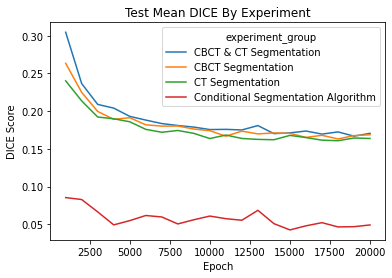

In [37]:
plot_data_aggregate(exp_types, "'test'", "'dice_mean'", 20000, 1000, title='Test Mean DICE By Experiment', y_label = 'DICE Score')